- 3 different exercises: sitting, standing and walking in the muscles: biceps femoris, vastus medialis, rectus femoris and semitendinosus addition to goniometry in the exercises.

Each data file contains 5 columns, organized as follows.
Segment	Lower Limb
Channel	Ch1	Ch2	Ch3	Ch4	Ch5
Muscle	RF	BF	VM	ST	FX
Column	0	1	2	3	4


- 2.1. Protocol:
22 male subjects , 11 with different knee abnormalities previously diagnosed by a professional. They undergo three movements to analyze the behavior associated with the knee muscle , gait , leg extension from a sitting position , and flexion of the leg up. The acquisition process was conducted with 4 electrodes ( Vastus Medialis , semitendinosus , biceps femoris and rectus femoris ) and the goniometer in the knee .

- 2.2.	Instrumentation
Datalog equipment was used MWX8 by Biometrics of 8 digital channels and 4 analog channels , of which 4 for sampling were used SEMG and 1 for goniometry, these data were acquired directly to the computer MWX8 internal storage with microSD card and transmitted in Real-time Datalog software through bluetooth adapter , 14-bit resolution and sampling frequency of 1000Hz .

- 2.3.	Data configuration:
The total number of electrodes is 4, corresponding to the time series one for each channel (1 to 4). Each series contains ~ 5 shares or motion repetitions for each subject.

## No sessions exist


# Intra-subject

### Obj. 1
1. Subject 별로 train-test split 써서 학습 / 테스트
2. feature extraction using multiple features / windows
- use normal only

### Obj. 2
- Cross-subject 시에 사용 가능 -> few-shot adaptation

### Obj. 3
- Federated Learning with multiple subjects

In [1]:
import numpy as np
import pandas as pd
import sys, os
import warnings
warnings.filterwarnings('ignore')

def call_data(base_path, sub_lst, sub_idx):
    data = pd.read_csv(base_path+sub_lst[sub_idx])
    return data


path_abnormal = "../../../Data/Gait1/Abnormal/"
path_normal = "../../../Data/Gait1/normal/"

lst_abnormal = os.listdir(path_abnormal)
lst_normal = os.listdir(path_normal)


def data_setup(lst_normal):
    subjects_data = defaultdict(list)
    subjects_label = defaultdict(list)

    for s_idx, filename in enumerate(lst_normal):
        name = filename.lower()
        subject_id = name.split("n")[0]
        data = call_data(path_normal, lst_normal, s_idx).to_numpy()  # (num_samples, num_channels)

        windows = processing.sliding_window(data, window_size, step_size)  # (num_windows, win_len, ch)

        if "standing" in name: label = 0
        elif "gait" in name: label = 1
        elif "sitting" in name: label = 2
        else: label = -1

        labels = np.full(len(windows), label)

        subjects_data[subject_id].append(windows)
        subjects_label[subject_id].append(labels)

    return subjects_data, subjects_label



def get_X_y(X, y):
    all_X, all_y = [], []

    #for subject_id in subjects_data.keys():
    data_list = X
    label_list = y

    for data, labels in zip(data_list, label_list):
        for w, label in zip(data, labels):  # w: (win_len, ch)
            feat = processing.extract_features(w)  # (num_channels*5,)
            all_X.append(feat)
            all_y.append(label)

    all_X, all_y = np.array(all_X), np.array(all_y)   # (N, num_channels*5)
    all_X = all_X.reshape(-1, num_channels, num_features, 1)

    return all_X, all_y

Feature shape for CNN: (7139, 5, 5, 1)


C:\Users\hml76\PycharmProjects\Cross-motor-decoding\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


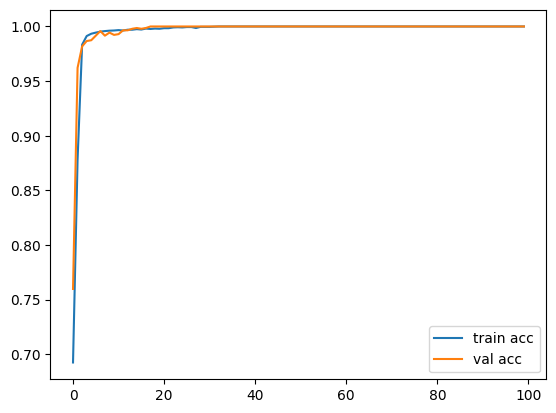

Feature shape for CNN: (3281, 5, 5, 1)


In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

sys.path.append('../Shared')
import processing, Model, Visualization

window_size, step_size = 200, 10
num_channels, num_features = 5, 5  # we extracted 5 features per channel

subjects_data, subjects_label = data_setup(lst_normal)

for subject_id in subjects_data.keys():
    X, y = get_X_y(X=subjects_data[subject_id], y=subjects_label[subject_id])
    print("Feature shape for CNN:", X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = Model.build_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y)))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=0)
    Visualization.learning_plot(history)